In [1]:
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

## Core Market Simulation: 
This section defines the fundamental components of a financial market. 
It includes:
 *Order class*
 >> which represents individual buy or sell orders
 *LimitOrderBook class*
 >>which is the central marketplace where orders are collected, matched, and executed. 
 
Together they form the backbone of the market simulation.



In [ ]:
def gen_order_id():
    
    """
    A generator function to produce a stream of unique order IDs.
    Each ID is a string in the format 'O{i}'.
    """
    i = 0
    while True:
        yield f"O{i}"
        i += 1

In [4]:
_order_id_gen = gen_order_id()
_order_id_gen

<generator object gen_order_id at 0x00000206FFA74640>

In [ ]:
class Order:
    """
    Represents a single order in the limit order book.
    """
    
    
    def __init__(self, trader_id, side, price, size, order_type='limit', timestamp=0):
        """
        Initializes an Order object.

        Args:
            trader_id (str): The unique identifier for the trader placing the order.
            side (str): The side of the order, either 'bid' (a buy order) or 'ask' (a sell order).
            price (int): The price of the order in ticks. Can be None for market orders.
            size (int): The quantity of the asset to be traded.
            order_type (str, optional): The type of order, 'limit' or 'market'. Defaults to 'limit'.
            timestamp (int, optional): The simulation time at which the order was placed. Defaults to 0.
        """
        self.id = next(_order_id_gen)
        self.trader_id = trader_id
        self.side = side  # 'bid' or 'ask'
        self.price = price  # integer ticks or None for market
        self.size = size
        self.remaining = size
        self.type = order_type  # 'limit' or 'market'
        self.timestamp = timestamp

In [ ]:
class LimitOrderBook:

    """
    Implements a limit order book (LOB) for a single financial asset.
    It handles order placing, matching, and cancellation.
    """


    def __init__(self, mid_price=10000, tick_size=1, max_levels=100):
        """
        Initializes an Order object.

        Args:
            trader_id (str): The unique identifier for the trader placing the order.
            side (str): The side of the order, either 'bid' (a buy order) or 'ask' (a sell order).
            price (int): The price of the order in ticks. Can be None for market orders.
            size (int): The quantity of the asset to be traded.
            order_type (str, optional): The type of order, 'limit' or 'market'. Defaults to 'limit'.
            timestamp (int, optional): The simulation time at which the order was placed. Defaults to 0.
        """

        self.mid_price = mid_price
        self.tick = tick_size
        self.bids = defaultdict(deque)
        self.asks = defaultdict(deque)
        self.bids_prices = set()
        self.asks_prices = set()
        self.order_map = {}  # order_id -> (order, container)
        self.trade_history = []  # (time, price, size, taker_id, maker_id)
        self.time = 0
        self.max_levels = max_levels
        # Per-trader accounting (inventory, cash)
        self.trader_inventory = defaultdict(int)
        self.trader_cash = defaultdict(float)

    def best_bid(self):
        """Returns the highest bid price currently in the book."""
        return max(self.bids_prices) if self.bids_prices else None

    def best_ask(self):
        """Returns the lowest ask price currently in the book."""
        return min(self.asks_prices) if self.asks_prices else None

    def mid(self):
        """Calculates the current mid-price of the market."""

        bb = self.best_bid()
        ba = self.best_ask()
        if bb is None and ba is None:
            return self.mid_price
        if bb is None:
            return ba - self.tick
        if ba is None:
            return bb + self.tick
        return (bb + ba) / 2.0

    def place_limit_order(self, order: Order):
        """
        Places a limit order in the book. If the order is marketable (crosses the spread),
        it will be matched against existing orders. Otherwise, it's added to the book.
        """

        # match if crossing
        if order.side == 'bid':
            if self.best_ask() is not None and order.price >= self.best_ask():
                self._match_order(order)
                if order.remaining > 0:
                    self._add_to_book(order)
            else:
                self._add_to_book(order)
        else:
            if self.best_bid() is not None and order.price <= self.best_bid():
                self._match_order(order)
                if order.remaining > 0:
                    self._add_to_book(order)
            else:
                self._add_to_book(order)

    def place_market_order(self, side, size, trader_id):
        """Places a market order, which is immediately matched against the best available orders."""

        order = Order(trader_id=trader_id, side=side, price=None, size=size, order_type='market', timestamp=self.time)
        self._match_order(order)
        return order

    def _add_to_book(self, order):
        """A helper function to add a limit order to the appropriate side of the book."""

        container = self.bids if order.side == 'bid' else self.asks
        prices_set = self.bids_prices if order.side == 'bid' else self.asks_prices
        container[order.price].append(order)
        prices_set.add(order.price)
        self.order_map[order.id] = (order, container)
        # trim far levels
        if len(prices_set) > self.max_levels:
            if order.side == 'bid':
                far = min(prices_set)
                while container[far]:
                    o = container[far].popleft()
                    self.order_map.pop(o.id, None)
                del container[far]
                prices_set.remove(far)
            else:
                far = max(prices_set)
                while container[far]:
                    o = container[far].popleft()
                    self.order_map.pop(o.id, None)
                del container[far]
                prices_set.remove(far)

    def _match_order(self, taker_order: Order):
        """
        Matches a 'taker' order against existing 'maker' orders in the book.
        This function handles the logic for trade execution and updating accounts.
        """

        if taker_order.side == 'bid':
            opposite = self.asks
            opp_prices = sorted(self.asks_prices)
            price_cmp = lambda p: p <= taker_order.price if taker_order.price is not None else True
        else:
            opposite = self.bids
            opp_prices = sorted(self.bids_prices, reverse=True)
            price_cmp = lambda p: p >= taker_order.price if taker_order.price is not None else True

        for p in opp_prices:
            if taker_order.price is not None and not price_cmp(p):
                break
            queue = opposite[p]
            while queue and taker_order.remaining > 0:
                maker = queue[0]
                trade_size = min(maker.remaining, taker_order.remaining)
                trade_price = maker.price if maker.price is not None else p
                # record
                self.trade_history.append((self.time, trade_price, trade_size,
                                           taker_order.trader_id if taker_order.side=='bid' else maker.trader_id,
                                           maker.trader_id if taker_order.side=='bid' else taker_order.trader_id))
                # update accounting: buyer inventory +, buyer cash -, seller inventory -, seller cash +
                if taker_order.side == 'bid':
                    buyer = taker_order.trader_id
                    seller = maker.trader_id
                else:
                    buyer = maker.trader_id
                    seller = taker_order.trader_id
                # apply cash/inventory transfer at trade_price
                self.trader_inventory[buyer] += trade_size
                self.trader_inventory[seller] -= trade_size
                self.trader_cash[buyer] -= trade_price * trade_size
                self.trader_cash[seller] += trade_price * trade_size

                maker.remaining -= trade_size
                taker_order.remaining -= trade_size
                if maker.remaining == 0:
                    queue.popleft()
                    self.order_map.pop(maker.id, None)
                if not queue:
                    if taker_order.side == 'bid':
                        self.asks_prices.discard(p)
                        del self.asks[p]
                    else:
                        self.bids_prices.discard(p)
                        del self.bids[p]
                if taker_order.remaining == 0:
                    break

    def cancel_order(self, order_id):
        """Removes an order from the book by its ID."""
        if order_id not in self.order_map:
            return False
        order, container = self.order_map.pop(order_id)
        q = container[order.price]
        newq = deque([o for o in q if o.id != order_id])
        container[order.price] = newq
        if not newq:
            if container is self.bids:
                self.bids_prices.discard(order.price)
                del self.bids[order.price]
            else:
                self.asks_prices.discard(order.price)
                del self.asks[order.price]
        return True

    def step_time(self):
        self.time += 1


# Trader Agents: 
To create a realistic market environment, different types of traders are simulated. 
The *NoiseTrader* places random market orders to simulate general market activity,
 while the *InformedTrader* occasionally places large orders based on a "signal," mimicking traders with insider information that can move the market

In [ ]:
class NoiseTrader:
    """
    A simple trader agent that places random market orders to simulate
    uninformed trading activity in the market.
    """

    def __init__(self, trader_id, market: LimitOrderBook, rate=0.2):
        self.id = trader_id
        self.mkt = market
        self.rate = rate

    def act(self):
        if random.random() < self.rate:
            side = random.choice(['bid', 'ask'])
            size = random.randint(1, 3)
            self.mkt.place_market_order(side=side, size=size, trader_id=self.id)


In [ ]:
class InformedTrader:
    """
    A trader agent that simulates having private information. It occasionally
    places large, directional market orders.
    """

    def __init__(self, trader_id, market: LimitOrderBook, info_prob=0.05, strength=4):
        self.id = trader_id
        self.mkt = market
        self.info_prob = info_prob
        self.strength = strength

    def act(self, signal=None):
        """
        Acts based on a signal. If no signal is given, there's a small
        chance one is generated. A positive signal leads to a buy, a negative to a sell.
        """

        if signal is None:
            if random.random() < self.info_prob:
                signal = random.choice([1, -1])
            else:
                return
        if signal == 1:
            self.mkt.place_market_order(side='bid', size=self.strength, trader_id=self.id)
        elif signal == -1:
            self.mkt.place_market_order(side='ask', size=self.strength, trader_id=self.id)


# Market Maker Environment: 

This is the heart of our reinforcement learning (RL) setup. 

The MarketMakerEnv class incoporates the Limit Order Book and the trader agents to create an environment where a reinforcement learning agent can act as a market maker. 

This class handles the state representation (what the market maker agent sees), the action space (what the agent can do), and the reward function (how the agent is evaluated).



In [9]:
class MarketMakerEnv:
    """
    The reinforcement learning environment for the market maker agent.
    This class defines the state, actions, and rewards for the agent.
    """

    def __init__(self,
                 mid_price=1000,
                 tick=1,
                 top_k=5,
                 agent_id="MM",
                 num_noise=5,
                 seed_liquidity=10):
        self.lob = LimitOrderBook(mid_price=mid_price, tick_size=tick, max_levels=200)
        self.agent_id = agent_id
        self.top_k = top_k
        self.noise_traders = [NoiseTrader(f"N{i}", self.lob, rate=0.25) for i in range(num_noise)]
        self.informed = InformedTrader("I1", self.lob, info_prob=0.05, strength=6)
        self.seed_liquidity = seed_liquidity
        self.last_agent_orders = []  # track to cancel each step
        self.reset()

    def reset(self):
        """
        Resets the environment to a new, clean state. This is called at the
        beginning of each new simulation episode.
        """
        # reset LOB structure fresh
        self.lob = LimitOrderBook(mid_price=self.lob.mid_price, tick_size=self.lob.tick, max_levels=self.lob.max_levels)
        # seed book
        mid = self.lob.mid_price
        for p in range(mid-10, mid):
            o = Order(trader_id="seed", side='bid', price=p, size=random.randint(self.seed_liquidity-5, self.seed_liquidity+5),
                      order_type='limit', timestamp=0)
            self.lob.place_limit_order(o)
        for p in range(mid+1, mid+11):
            o = Order(trader_id="seed", side='ask', price=p, size=random.randint(self.seed_liquidity-5, self.seed_liquidity+5),
                      order_type='limit', timestamp=0)
            self.lob.place_limit_order(o)
        # reset traders' accounting
        self.lob.trader_inventory = defaultdict(int)
        self.lob.trader_cash = defaultdict(float)
        self.lob.trader_inventory[self.agent_id] = 0
        self.lob.trader_cash[self.agent_id] = 0.0
        self.last_agent_orders = []
        self.steps = 0
        return self._get_obs()

    def _get_obs(self):
        """
        Constructs the observation (state) vector for the RL agent.
        It includes information about the LOB, and the agent's own state.
        """
        # observation: top_k bid sizes and top_k ask sizes, agent inventory, mid-price, spread
        obs = []
        # bids top_k from best to worse
        bids = sorted(self.lob.bids_prices, reverse=True)[:self.top_k]
        asks = sorted(self.lob.asks_prices)[:self.top_k]
        for i in range(self.top_k):
            if i < len(bids):
                price = bids[i]
                size = sum([o.remaining for o in self.lob.bids[price]])
                obs.append(self.lob.mid_price - price)  # distance to mid (ticks)
                obs.append(size)
            else:
                obs.extend([99999, 0])
        for i in range(self.top_k):
            if i < len(asks):
                price = asks[i]
                size = sum([o.remaining for o in self.lob.asks[price]])
                obs.append(price - self.lob.mid_price)
                obs.append(size)
            else:
                obs.extend([99999, 0])
        # agent inventory and cash
        obs.append(self.lob.trader_inventory[self.agent_id])
        obs.append(self.lob.trader_cash[self.agent_id])
        # simple recent mid trend (difference over last step)
        obs.append(self.lob.mid() - self.lob.mid_price)
        return obs

    def _cancel_agent_orders(self):
        """A helper to cancel all of the agent's orders from the previous step."""

        for oid in self.last_agent_orders:
            self.lob.cancel_order(oid)
        self.last_agent_orders = []

    def step(self, action):
        """
        Executes one time step in the environment.
        This involves the agent taking an action, other traders acting,
        and then calculating the reward and next state.
        
        Args:
            action (int): An integer representing the agent's action. It's decoded
                          into bid and ask offsets from the mid-price.
        
        Returns:
            tuple: A tuple containing (observation, reward, done, info).
        """

        # Action: integer 0..15 mapping to (bid_offset 0..3, ask_offset 0..3). Size fixed 1.
        bid_off = action // 4
        ask_off = action % 4
        size = 1
        self.steps += 1

        # cancel previous agent orders (simple design)
        self._cancel_agent_orders()

        mid = int(self.lob.mid())
        bid_price = mid - bid_off if bid_off >= 0 else mid
        ask_price = mid + ask_off + 1  # ensure ask > bid by at least 1 tick

        # place agent limit orders
        bid_order = Order(trader_id=self.agent_id, side='bid', price=bid_price, size=size, order_type='limit', timestamp=self.lob.time)
        ask_order = Order(trader_id=self.agent_id, side='ask', price=ask_price, size=size, order_type='limit', timestamp=self.lob.time)
        self.lob.place_limit_order(bid_order)
        self.lob.place_limit_order(ask_order)
        self.last_agent_orders = [bid_order.id, ask_order.id]

        # Other traders act
        for nt in self.noise_traders:
            nt.act()
        # occasional informed signal: we simulate detection from latent small prob
        future_signal = None
        if random.random() < 0.02:
            future_signal = random.choice([1, -1])
        self.informed.act(signal=future_signal)

        # step time and return observation
        self.lob.step_time()

        # compute reward: delta wealth (cash + inventory*mid) since last step minus inventory penalty
        mid_now = self.lob.mid()
        wealth = self.lob.trader_cash[self.agent_id] + self.lob.trader_inventory[self.agent_id] * mid_now
        # we store previous wealth on env object
        prev_wealth = getattr(self, "prev_wealth", 0.0)
        reward = wealth - prev_wealth
        # inventory penalty (quadratic)
        inv = self.lob.trader_inventory[self.agent_id]
        inv_penalty = -0.1 * (inv**2)
        reward += inv_penalty

        self.prev_wealth = wealth

        obs = self._get_obs()

        # simple done condition: run for fixed horizon
        done = self.steps >= 500

        info = {"wealth": wealth, "inventory": inv, "mid": mid_now, "trade_count": len(self.lob.trade_history)}

        return obs, reward, done, info

# Simulation and Visualization: 

This final part of the code initializes the MarketMakerEnv, runs a simulation loop where the market maker agent takes random actions, and then uses matplotlib to plot the agent's performance over time, specifically its profit and loss (PnL), inventory, and the mid-price of the market.



In [10]:
env = MarketMakerEnv(mid_price=1000, tick=1, top_k=3, num_noise=6, seed_liquidity=12)
obs = env.reset()

pnl = []
inventory = []
mid_series = []
times = []

In [11]:
for t in range(300):
    action = random.randrange(16)  # random action from 0..15
    obs, reward, done, info = env.step(action)
    pnl.append(info["wealth"])
    inventory.append(info["inventory"])
    mid_series.append(info["mid"])
    times.append(t)
    if done:
        break

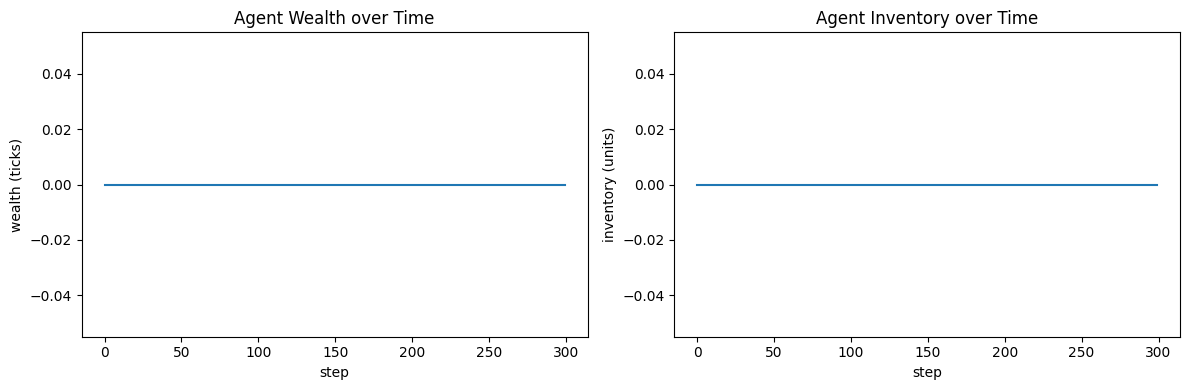

Total trades: 0
Final wealth, inventory: 0.0 0


In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(times, pnl)
plt.title("Agent Wealth over Time")
plt.xlabel("step")
plt.ylabel("wealth (ticks)")

plt.subplot(1,2,2)
plt.plot(times, inventory)
plt.title("Agent Inventory over Time")
plt.xlabel("step")
plt.ylabel("inventory (units)")
plt.tight_layout()
plt.show()

print("Total trades:", len(env.lob.trade_history))
print("Final wealth, inventory:", pnl[-1], inventory[-1])

In [13]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
from gym import spaces
warnings.filterwarnings('ignore')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [14]:
class MarketMakerEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super(MarketMakerEnv, self).__init__()

        # Action space: 16 discrete actions (bid_offset 0–3 × ask_offset 0–3)
        self.action_space = spaces.Discrete(16)

        # Observation space: [mid_price, spread, depth_bid, depth_ask, inventory, wealth]
        # Normalize by reasonable ranges
        obs_low  = np.array([0, 0, 0, 0, -100, -1e6], dtype=np.float32)
        obs_high = np.array([1e6, 1e3, 1e4, 1e4, 100, 1e6], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        # Parameters for penalties
        self.inventory_limit = 100
        self.inventory_penalty_coeff = 0.1
        self.transaction_fee_rate = 0.001  
        # Internal state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.mid_price = 100.0
        self.spread = 1.0
        self.depth_bid = 30
        self.depth_ask = 30
        self.agent_inventory = 0
        self.agent_wealth = 0.0

        obs = np.array([self.mid_price, self.spread, self.depth_bid,
                        self.depth_ask, self.agent_inventory, self.agent_wealth],
                    dtype=np.float32)
        info = {}  # you can add extra debug info here later
        return obs, info

    def step(self, action):
        bid_offset = action // 4
        ask_offset = action % 4

        trade_direction = np.random.choice([-1, 0, 1])   # -1 sell, +1 buy, 0 no trade
        trade_size = np.random.choice([0,1,2])

        self.agent_inventory += trade_direction * trade_size
        self.agent_wealth += trade_size * (0.5 * (ask_offset - bid_offset))

        self.mid_price += np.random.normal(0, 0.1)
        self.spread = ask_offset + bid_offset + 1

        obs = np.array([self.mid_price, self.spread, self.depth_bid,
                        self.depth_ask, self.agent_inventory, self.agent_wealth],
                    dtype=np.float32)
        prev_wealth = self.agent_wealth
        # current reward
        
        reward = self.agent_wealth - prev_wealth  

        # add penalty
        reward -= self.inventory_penalty_coeff * (self.agent_inventory ** 2)

        
        terminated = False  # no terminal condition yet
        truncated = False   # no time-limit truncation yet
        info = {}
        if abs(self.agent_inventory) > self.inventory_limit:
            done = True
            reward -= 1000
        return obs, reward, terminated, truncated, info

    def render(self, mode="human"):
        print(f"Price {self.mid_price:.2f}, Wealth {self.agent_wealth:.2f}, Inv {self.agent_inventory}")

In [15]:
env = DummyVecEnv([lambda: MarketMakerEnv()])

model = PPO(
    "MlpPolicy", env, verbose=1,
    learning_rate=3e-5,
    gamma=0.99,
    n_steps=512,
    batch_size=64,
    ent_coef=0.01,
    tensorboard_log="./mm_tensorboard/",
    device="cuda"
)

# Train agent
timesteps = 50_000
model.learn(total_timesteps=timesteps)

# Save trained model
model.save("ppo_market_maker")
print("Training done and model saved!")

Using cpu device
Logging to ./mm_tensorboard/PPO_1
-----------------------------
| time/              |      |
|    fps             | 1790 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 955           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 3.3077435e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.77         |
|    explained_variance   | -0.000216     |
|    learning_rate        | 3e-05         |
|    loss                 | 1.32e+05      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000722     |
|    value_loss           | 2.85e+0

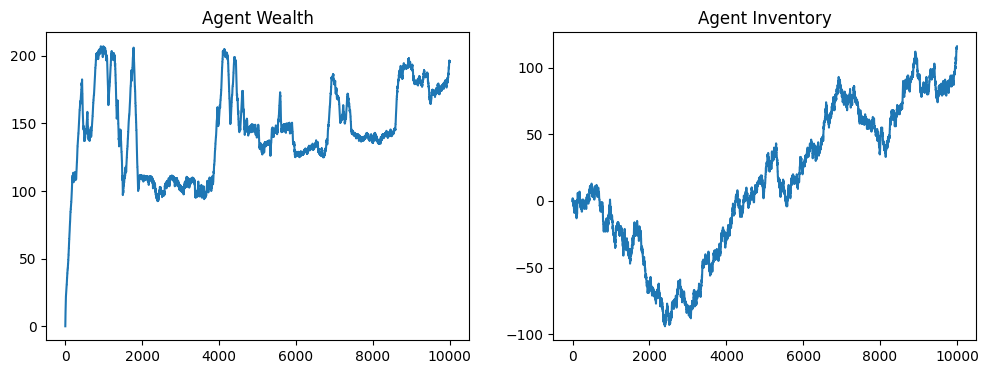

In [16]:
# Wrap in DummyVecEnv
eval_env = DummyVecEnv([lambda: MarketMakerEnv()])

# Load model
model = PPO.load("ppo_market_maker")

obs = eval_env.reset()
wealth_history, inventory_history = [], []

for step in range(10000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    wealth_history.append(eval_env.envs[0].agent_wealth)
    inventory_history.append(eval_env.envs[0].agent_inventory)
    if done:
        obs = eval_env.reset()

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(wealth_history)
plt.title("Agent Wealth")
plt.subplot(1,2,2)
plt.plot(inventory_history)
plt.title("Agent Inventory")
plt.show()
